# A simple example of lensing estimator modules
This code compute normalization and power spectrum of quadratic estiamtors

In [1]:
# external
import numpy as np
from matplotlib.pyplot import *
import tqdm 
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import binning as bn
import cmb

First define parameters

In [2]:
Tcmb  = 2.726e6    # CMB temperature
Lmax  = 512       # maximum multipole of output normalization
rlmin, rlmax = 100, Lmax  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/(2*np.pi)
nside = 1024
qlist = ['TT','TE','EE','TB','EB'] # list of quadratic estimators for MV in simulation
#qlist = ['EB']
qid = {'TT':0,'TE':1,'EE':2,'TB':3,'EB':4,'MV':5}
simn = 200

Load arrays of CMB unlensed and lensed Cls. Unlensed Cls are not used for now. The Cls should not be multiplied by any factors and should not have units.  

In [3]:
# lcl is an array of shape [0:4,0:rlmax+1] and lcl[0,:] = TT, lcl[1,:] = EE, lcl[2,:] = BB, and lcl[3,:] = TE
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:rlmax+1] # TT, EE, BB, TE

Define observed CMB cls. Here, no CMB noise.

In [4]:
ocl = lcl.copy() # observed Cl (here, no CMB noise)

In [5]:
lcl[2] = 0. # no primordial B

### Compute normalization

QDO below specifies which normalizations will be computed: TT, TE, EE, TB, EB, BB (currently BB is ignored even if you set True)

MV is also automatically computed from these specified estimators

In [6]:
QDO = [True,True,True,True,True,False] # this means that TT, TE, EE, TB and EB are used for MV estimator

"Wg" ("Wc") below is the optimal weight for constructing the MV estimator; $$\phi^{MV} = A^{MV}\sum_q W_q \phi^q$$ where $W$ is Wg (Wc) and $q = TT, TE, \dots$. 
BB is not output, and the array has 6 normalizations (TT, TE, EE, TB, EB and MV)

In [7]:
Ag, Ac, Wg, Wc = cs.norm_quad.qall('lens',QDO,Lmax,rlmin,rlmax,lcl,ocl)

### Comparison with a simple simulation

In [8]:
# diagonal C^-1 filtering
Fl = np.zeros((3,rlmax+1,rlmax+1)) # the first index means 0=T, 1=E, 2=B
for l in range(rlmin,rlmax+1):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [9]:
cl = {q: np.zeros((simn,2,Lmax+1)) for q in (qlist+['MV']) }
#CL = {q: np.zeros((simn,Lmax+1)) for q in ['TT','EE','BB'] }

In [10]:
for i in tqdm.tqdm(range(simn)):
    Talm, Ealm, Balm = cs.utils.gaussTEB(rlmax,ocl[0,:],ocl[1,:],ocl[2,:],ocl[3,:])
    #CL['EE'][i,:] = cs.utils.alm2cl(Lmax,Ealm)
    #CL['BB'][i,:] = cs.utils.alm2cl(Lmax,Balm)
    # multiply filter to alms
    Talm *= Fl[0,:,:]
    Ealm *= Fl[1,:,:]
    Balm *= Fl[2,:,:]
    glm, clm = {}, {}
    glm['TT'], clm['TT'] = cs.rec_lens.qtt(Lmax,rlmin,rlmax,lcl[0,:],Talm,Talm,nside_t=nside)
    glm['TE'], clm['TE'] = cs.rec_lens.qte(Lmax,rlmin,rlmax,lcl[3,:],Talm,Ealm,nside_t=nside)
    glm['EE'], clm['EE'] = cs.rec_lens.qee(Lmax,rlmin,rlmax,lcl[1,:],Ealm,Ealm,nside_t=nside)
    glm['TB'], clm['TB'] = cs.rec_lens.qtb(Lmax,rlmin,rlmax,lcl[3,:],Talm,Balm,nside_t=nside)
    glm['EB'], clm['EB'] = cs.rec_lens.qeb(Lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm,nside_t=nside)
    for q in qlist:
        glm[q] *= Ag[qid[q],:,None]
        clm[q] *= Ac[qid[q],:,None]
    # combine each quadratic estimator to the MV estimator
    glm['MV'], clm['MV'] = 0., 0.
    for q in qlist:
        glm['MV'] += Wg[qid[q],:,None]*glm[q]
        clm['MV'] += Wc[qid[q],:,None]*clm[q]
    glm['MV'] *= Ag[5,:,None]
    clm['MV'] *= Ac[5,:,None]
    # compute cl of the MV estimator
    for q in (qlist+['MV']):
        cl[q][i,0,:] = cs.utils.alm2cl(Lmax,glm[q])
        cl[q][i,1,:] = cs.utils.alm2cl(Lmax,clm[q])

100%|██████████| 200/200 [18:49<00:00,  5.65s/it]


In [11]:
# plot spectra (gradient)
#mb = bn.multipole_binning(200,lmin=4,lmax=Lmax)
#pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,ymin=.9,ymax=1.1,grid=True,ylab=r'ratio')
#for qi, (c, clid, ls, q) in enumerate([('k',1,'-','EE'),('g',2,'--','BB')]):
#    mCL = np.mean(CL[q],axis=0)
#    mCb = bn.binning(mCL/lcl[clid],mb)
#    plot(mb.bc,mCb,color=c,ls=ls,label=q)
#legend()

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


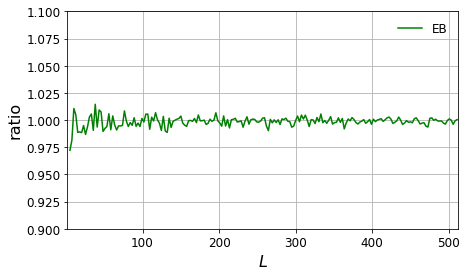

In [12]:
# plot spectra (gradient)
mb = bn.multipole_binning(200,lmin=4,lmax=Lmax)
#Ab = bn.binning(Ag[5,:],mb)
#pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,ymin=.96,ymax=1.04,grid=True,ylab=r'ratio')
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,ymin=.9,ymax=1.1,grid=True,ylab=r'ratio')
for qi, (c, q) in enumerate([('g','EB')]):
#for qi, (c, q) in enumerate([('k','MV'),('g','EB')]):
    mcl = np.mean(cl[q],axis=0)
    mcb = bn.binning(mcl[0,:]/Ag[qid[q]],mb)
    plot(mb.bc,mcb,color=c,ls='-',label=q)
    #plot(Ag[qid[q]]/AgEB)
legend()